In [9]:
import numpy as np
import torch

ignore_first_n_bars = 4

# load generations
generated_drums = torch.tensor(np.load('vel_itzc90b6_120.pth_gens/2BarsPrimed_0.5THresh_NoBernouli/generated_drums.npy')[:, ignore_first_n_bars*16:, :9])
generated_grooves = torch.tensor(np.load('vel_itzc90b6_120.pth_gens/2BarsPrimed_0.5THresh_NoBernouli/generated_grooves.npy')[:, ignore_first_n_bars*16:, :1])
gt_drums = torch.tensor(np.load('vel_itzc90b6_120.pth_gens/2BarsPrimed_0.5THresh_NoBernouli/drum_hvos_gt.npy')[:, ignore_first_n_bars*16:, :9])
gt_grooves = torch.tensor(np.load('vel_itzc90b6_120.pth_gens/2BarsPrimed_0.5THresh_NoBernouli/groove_hvos_gt.npy')[:, ignore_first_n_bars*16:, :1])

# 

In [10]:
def jaccard(hvo_1, hvo_2):
    hvo_1 = hvo_1.reshape(hvo_1.shape[0], -1)
    hvo_2 = hvo_2.reshape(hvo_2.shape[0], -1)
    intersection = torch.sum(hvo_1 * hvo_2, dim=1)
    union = torch.sum(hvo_1 + hvo_2, dim=1)
    return intersection / (union - intersection)

def extract_segments(hvo_, n_bars_per_seg):
    n_bars = hvo_.shape[1] // 16
    n_segs = n_bars // n_bars_per_seg
    hvo_ = hvo_[:, :n_segs*n_bars_per_seg*16, :]
    hvo_ = hvo_.reshape(hvo_.shape[0], n_segs, n_bars_per_seg*16, hvo_.shape[2])
    return hvo_
    
def compute_intra_jaccards(hvo_, n_bars_per_seg):
    hvo_segments = extract_segments(hvo_, n_bars_per_seg)
    N = hvo_segments.shape[1]
    intra_jaccards = torch.zeros(hvo_segments.shape[0], N*(N-1)//2)
    count = 0
    for i in range(0, N-1):
        for j in range(i+1, N):
            intra_jaccards[:, count] = jaccard(hvo_segments[:, i, :, :], hvo_segments[:, j, :, :])
            count += 1
    return intra_jaccards


def compute_inter_jaccards(hvo_1, hvo_2, n_bars_per_seg):
    hvo_1_segments = extract_segments(hvo_1, n_bars_per_seg)
    hvo_2_segments = extract_segments(hvo_2, n_bars_per_seg)
    N = hvo_1_segments.shape[1]
    inter_jaccards = torch.zeros(hvo_1_segments.shape[0], N)
    
    for i in range(N):
        inter_jaccards[:, i] = jaccard(hvo_1_segments[:, i, :, :], hvo_2_segments[:, i, :, :])
        
    return inter_jaccards

In [11]:
# INTRA JACCARDS

intra_generation_jaccards = compute_intra_jaccards(generated_drums, 2)
intra_gt_jaccards = compute_intra_jaccards(gt_drums, 1)

# get box_plot data for each example
intra_gen_average = torch.mean(intra_generation_jaccards, dim=1)
intra_gt_average = torch.mean(intra_gt_jaccards, dim=1)

# get non_nan values
intra_gen_average = intra_gen_average[~torch.isnan(intra_gen_average)]
intra_gt_average = intra_gt_average[~torch.isnan(intra_gt_average)]



In [12]:
# INTER JACCARDS
inter_jaccards = compute_inter_jaccards(generated_drums, gt_drums, 2).mean(dim=1)
inter_jaccards = inter_jaccards[~torch.isnan(inter_jaccards)]




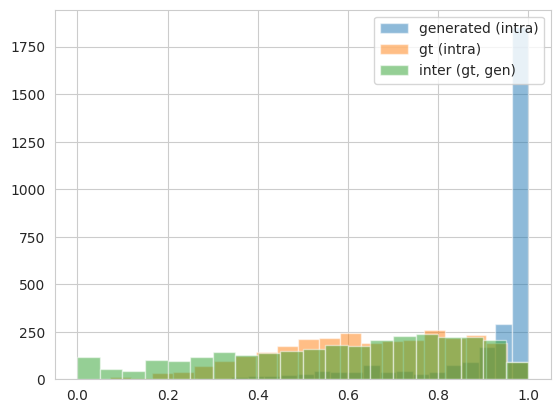

In [13]:
# show histograms
import matplotlib.pyplot as plt
plt.hist(intra_gen_average, bins=20, alpha=0.5, label='generated (intra)')
plt.hist(intra_gt_average, bins=20, alpha=0.5, label='gt (intra)')
plt.hist(inter_jaccards.flatten(), bins=20, alpha=0.5, label='inter (gt, gen)')

plt.legend(loc='upper right')
plt.show()

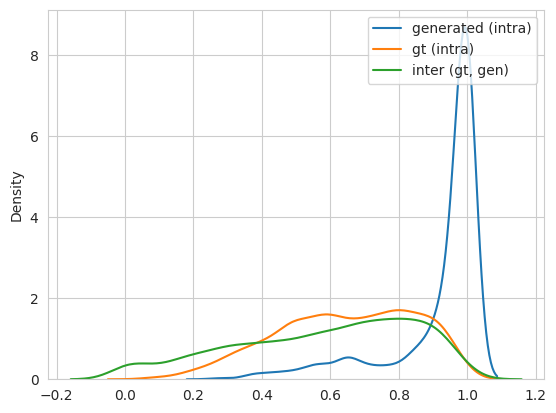

In [14]:
# show pdf using scott's rule
import seaborn as sns
sns.kdeplot(intra_gen_average, bw_method='scott', label='generated (intra)')
sns.kdeplot(intra_gt_average, bw_method='scott', label='gt (intra)')
sns.kdeplot(inter_jaccards.flatten(), bw_method='scott', label='inter (gt, gen)')
plt.legend(loc='upper right')
plt.show()